In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = []
val = []

#get paths to all of the images
path = '/Users/kanishk/Downloads/vscode/python/machine learning/data/Melanoma'
pt_b = path + '/train/benign'
pt_m = path + '/train/malignant'
pv_b = path + '/test/benign'
pv_m = path + '/test/malignant'
train_b = os.listdir(pt_b)
train_m = os.listdir(pt_m)
val_b = os.listdir(pv_b)
val_m = os.listdir(pv_m)

#prepare data + add it to the datasets
length = 200
shape = (length, length)

trans = transforms.Compose([transforms.Resize(shape), transforms.ToTensor()])

for file in train_b:
    acc = []
    img = Image.open(os.path.join(pt_b, file))
    img = trans(img)
    acc.append(img)
    acc.append(torch.tensor(0.0))
    train.append(acc)
    
for file in train_m:
    acc = []
    img = Image.open(os.path.join(pt_m, file))
    img = trans(img)
    acc.append(img)
    acc.append(torch.tensor(1.0))
    train.append(acc)
    
for file in val_b:
    acc = []
    img = Image.open(os.path.join(pv_b, file))
    img = trans(img)
    acc.append(img)
    acc.append(torch.tensor(0.0))
    val.append(acc)
    
for file in val_m:
    acc = []
    img = Image.open(os.path.join(pv_m, file))
    img = trans(img)
    acc.append(img)
    acc.append(torch.tensor(1.0))
    val.append(acc)

In [3]:
train[0]

[tensor([[[0.7608, 0.7686, 0.7765,  ..., 0.7294, 0.7137, 0.6980],
          [0.7647, 0.7725, 0.7804,  ..., 0.7176, 0.7059, 0.7059],
          [0.7647, 0.7765, 0.7882,  ..., 0.7137, 0.7059, 0.7137],
          ...,
          [0.7137, 0.7176, 0.7255,  ..., 0.6510, 0.6431, 0.6314],
          [0.7059, 0.7098, 0.7176,  ..., 0.6471, 0.6353, 0.6235],
          [0.6980, 0.7020, 0.7098,  ..., 0.6353, 0.6235, 0.6157]],
 
         [[0.6078, 0.6157, 0.6235,  ..., 0.5765, 0.5608, 0.5451],
          [0.6118, 0.6196, 0.6275,  ..., 0.5647, 0.5529, 0.5529],
          [0.6118, 0.6235, 0.6353,  ..., 0.5608, 0.5529, 0.5608],
          ...,
          [0.5765, 0.5804, 0.5882,  ..., 0.4980, 0.4824, 0.4706],
          [0.5686, 0.5725, 0.5804,  ..., 0.4941, 0.4784, 0.4627],
          [0.5608, 0.5647, 0.5725,  ..., 0.4824, 0.4667, 0.4549]],
 
         [[0.6118, 0.6196, 0.6275,  ..., 0.5490, 0.5333, 0.5176],
          [0.6157, 0.6235, 0.6314,  ..., 0.5451, 0.5255, 0.5255],
          [0.6157, 0.6275, 0.6392,  ...,

In [4]:
print('train length: ' + str(len(train)))
print('validation length: ' + str(len(val)))

train length: 9605
validation length: 1000


In [5]:
#create the dataloaders + shuffle training data
size=25

trainloader = DataLoader(dataset=train, batch_size=size, shuffle=True)
valloader = DataLoader(dataset=val, batch_size=100, shuffle=True)

In [6]:
#create the neural network
torch.manual_seed(1)
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__() 
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(11, 11), padding=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, dilation=1)
        )
            
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, dilation=1)
        )
            
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, dilation=1)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2, dilation=1)
        )
        
        self.flat = nn.Flatten(1)
        self.linear1 = nn.Linear(256 * 5 * 5, 4000)
        self.drop1 = nn.Dropout(p=0.5, inplace=False)
        self.linear2 = nn.Linear(4000, 2000)
        self.drop2 = nn.Dropout(p=0.5, inplace=False)
        self.linear3 = nn.Linear(2000, 2)
        
            
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.drop1(x)
        x = self.linear2(x)
        x = self.drop2(x)
        x = self.linear3(x)
        return x 

    
#example --> nn.BCELoss()(model(train[0][0].unsqueeze(0)).max(1)[0], torch.tensor([1.0]))
model = Net()
model(train[0][0].unsqueeze(0))

tensor([[ 0.4293, -0.5686]], grad_fn=<AddmmBackward0>)

In [7]:
#create the loss function (Cross Entropy) and optimizer (Stochastic Gradient Descent)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0007, momentum=0.9)

In [8]:
#train the model + test accuracy each epoch
COST = []
ACCURACY = []

epochs = 4

tot = len(train)/size

for epoch in range(epochs):
    
    model.train()
    for i, (x,y) in enumerate(trainloader):
        y = y.long()
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        COST.append(loss.item())
        loss.backward()
        optimizer.step()
        if (i % tot/10 == 0):
            print(str((i/tot) * 100) + '% complete')
        
    correct = 0
    total = 0
    
    model.eval()
    for x,y in valloader:
        z = model(x)
        _,yhat = torch.max(z, 1)
        correct += (yhat == y).sum().item()
        total += len(y)
        
    accuracy = (correct/total) * 100
    ACCURACY.append(accuracy)
    print('epoch ' + str(epoch) + ' accuracy: ' + str(accuracy))

0.0% complete
epoch 0 accuracy: 86.9
0.0% complete
epoch 1 accuracy: 89.9
0.0% complete
epoch 2 accuracy: 91.0
0.0% complete
epoch 3 accuracy: 91.60000000000001


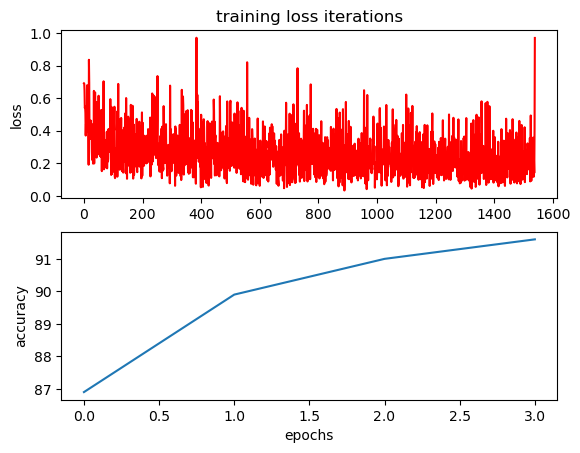

In [9]:
plt.subplot(2, 1, 1)
plt.plot(COST, 'r')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.subplot(2, 1, 2)
plt.plot(ACCURACY[0:8])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [10]:
torch.save(model.state_dict(), 'finalmodel.pt')